# Unigram Mixture model


##### The model :
First, we sample the topic of a document as a one-hot vector, from a multinomial of size $K$.
- $z \sim \mathcal{M}(1, (\pi_1, \dots, \pi_K)), z\in\{0, 1\}^K$
- $p(z)=\prod_{k=1}^K\pi_k^{z_k}$

Once the topic $z^i$ is selected for document $i$, we sample the documents $N$ words from a multinomial of size $d$, the vocabulary size.
- $w^i_n~|~\{z^i_k = 1\} \sim \mathcal{M}(1, (b_{1k},\dots,b_{dk}))$

In plate notations :
<img src="img/unigram_mixture_new.png" alt="unigram mixture" width="200"/>

Finally :
$\displaystyle{p(w^i, z^i) = \prod_{k=1}^K\pi_k^{z^i_k}\prod_{j=1}^d \prod_{n=1}^{N}(b_{jk})^{w^i_n(j)z^i_k}}$


### Question 0:
<p>Our first goal will be to sample documents according to this generating process. What is an alternative to sampling $N$ multinomials of size $1$ ? Write the new joint probability distribution and draw the new model in plate notation.</p>
<br/>
<br/>
<div style="color:red">
Instead of sampling $N$ multinomials of size $1$, we can sample $1$ multinomial of size $N$.

The new joint probability distribution is : $\displaystyle{p(x^i, z^i) \propto \prod_{k=1}^K\pi_k^{z^i_k}\prod_{j=1}^d (b_{jk})^{x^i_jz^i_k}}$. (as seen in class, the $\propto$ here comes to the binomial factor in the multinomial density).

The new plates notation corresponding to this is :
<img src="img/unigram_mixture_better.png" alt="unigram mixture, but faster" width="200"/>
</div>

### Question 1:
Sample $M=100$ documents of $N=30$ words from the given $\pi$ and $b$ in the next cell. We have $d=3$ words, but $K=6$ topics.
Write a function _gen_\__corpus_ that takes all the required parameters as input, and returns a (M,d) array containg the $x^{(i)}$, as well as a (M,) array containing the topics associated with these documents.

In [16]:
import numpy as np

n_docs = 100
doc_length = 30
n_topics = 6
n_tokens = 3

topic_proba = np.array([1./n_topics] * n_topics)
word_proba = np.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8],
    [0.45, 0.45, 0.1],
    [0.1, 0.45, 0.45],
    [0.45, 0.1, 0.45]
])

def gen_corpus(n_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba):
    corpus = np.empty((n_docs, n_tokens), dtype='float32')
    
    # sample the topics.
    topics = np.random.multinomial(1, topic_proba, size=(n_docs,))

    # Select corresponding multinomials
    for doc, topic in zip(range(n_docs), topics):
        # topic is a one-hot vector, use `where` to find where the 1 is
        t = np.where(topic)[0][0]
        # then sample the words using a multinomial of size doc_length
        corpus[doc] = np.random.multinomial(doc_length, word_proba[t, :])
    return corpus, topics

corpus, topics = gen_corpus(n_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)

### Visualizing the data :
In the next cell, we represent this corpus. We will use the three vertices of a triangle to represent our three tokens. A document will be represented as a convex combination of the three vertices. We will color each document according to their topic (red, green, blue and black).
Finally, each row in $b$ giving the token probability given the topic will also be visualized.

### Question 2:
Run the next cell to visualize the dataset. Explain what is shown in the figure produced.
<br/>
<br/>
<div style="color:red">
    The triangle represent the probability <em>simplex</em> of dimension $3$. Any point in that triangle can be represented as a convex combination $(p_1, p_2, p_3)$ of the three vertices (which are computed as complex roots of $1$). We represent each document by a point in this simplex, where $(p_1, p_2, p_3)$ are the frequencies of each of the three token in this document. Each document is colored according to its topic.
    
Finally, we also plot the multinomial parameters $b$ associated with each topic in the same way.
</div>

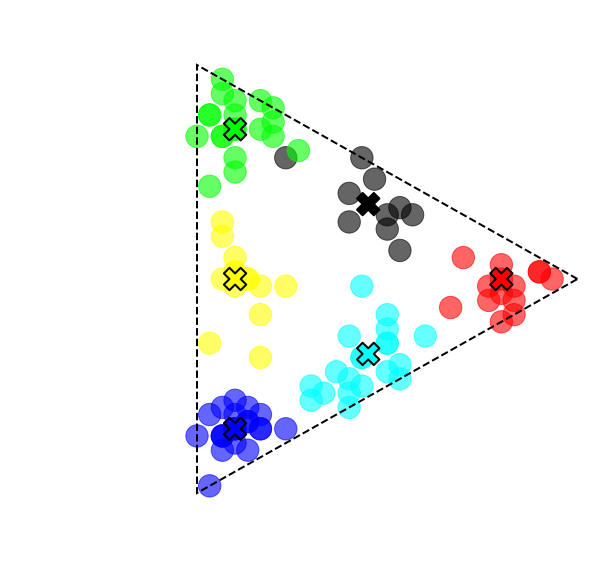

In [2]:
%matplotlib inline
import math

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Compute the triangle vertices using complex roots of 1
vertex_ids = np.array(range(n_tokens))
vertices = np.vstack([
    np.cos(2 * math.pi * vertex_ids / n_tokens),
    np.sin(2 * math.pi * vertex_ids / n_tokens)]
).T

# Plot the triangle
fig, ax = plt.subplots(figsize=(10, 10))
polygon = Polygon(vertices, fill=False, linewidth=2, linestyle='--')
ax.add_patch(polygon)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# Compute a S x 2 array containing documents as linear combination of our vertices

linear_combinations = (corpus / np.sum(corpus, axis=1)[:, None]) @ vertices  
colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0], [1, 1, 0], [0, 1, 1]])

plt.scatter(
    linear_combinations[:, 0], linear_combinations[:, 1], c=np.array(topics) @ colors,
    marker='o', s=500, alpha=0.6
)

centers = word_proba @ vertices

plt.scatter(
    centers[:, 0], centers[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)
plt.axis('off')

plt.show()

We observe documents $(x^{(i)})_{i=1..M}$, and apply EM for $t=1\dots T$.


##### E-Step:
- $\displaystyle{p(z_k=1~|~x^{(i)};b^{(t-1)};\pi^{(t-1)}) = \frac{\pi^{(t-1)}_k \prod_{j=1}^d(b_{jk}^{(t-1)})^{x_j}}{\sum_{k'=1}^K\pi^{(t-1)}_{k'}\prod_{j=1}^d(b_{jk'}^{(t-1)})^{x_j}}}$
- $q^{(t)}_{ik} = \mathbb{E}[z_k~|~x^{(i)};b^{(t)};\pi^{(t)}]$


##### M-Step:
- $\displaystyle{b_{jk}^{(t)} = \frac{\sum_{i}x_j^{(i)}q_{ik}^{(t)}}{\sum_{i,j'}x_{j'}^{(i)}q_{ik}^{(t)}}}$ and $\displaystyle{\pi_{k}^{(t)} = \frac{\sum_{i}q_{ik}^{(t)}}{\sum_{i,k'}q_{ik'}^{(t)}}}$


### Question 3:
1. Show the formula for $b^{(t)}_{jk}$ starting from the expected complete log-likelihood :
$$\mathbb{E}_{q_i^{(t)}}[\log(p(X, Z;b,\pi)]=\sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk}) + \sum_{i,k}q_{ik}^{(t)}\log(\pi_k)$$
<br/>
<br/>
<div style="color:red">
Our goal is to solve : 
$$\max_{b} \sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk}) + \sum_{i,k}q_{ik}^{(t)}\log(\pi_k)\quad \text{ such that } \forall k \sum_j b_{jk}=1$$
This is equivalent to solving :
$$\max_{b} \sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk})\quad \text{ such that } \forall k \sum_j b_{jk}=1$$
We write the Lagrangian :
$$\mathcal{L}(b, \lambda) = \sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk}) + \sum_{k=1}^K\lambda_k(1 - \sum_{j=1}^d b_{jk})$$
Finding critical points of $\nabla_{b_{:k}}\mathcal{L}(b, \lambda) = 0$ for all $k$ :
$$\forall j,~
\sum_{i}\frac{x_j^{(i)}q_{ik}^{(t)}}{b_{jk}} = \lambda_k \implies \sum_{i}\frac{x_j^{(i)}q_{ik}^{(t)}}{\lambda_k} = b_{jk}$$
We use our constraint on the $b_{jk}$:
$$1 = \sum_j b_{jk} = \sum_{i, j}\frac{x_j^{(i)}q_{ik}^{(t)}}{\lambda_k} \implies \lambda_k = \sum_{i, j}x_j^{(i)}q_{ik}^{(t)}$$
Finally, $\forall~j,k$:
$$b_{jk} = \frac{\sum_i x_j^{(i)}q_{ik}^{(t)}}{\sum_{i, j'}x_{j'}^{(i)}q_{ik}^{(t)}}$$

</div>
2. What problem can happen when computing the $q_{i,k}$ in the E step ?
<br/>
<br/>
<div style="color:red">
    The terms in the denominator can become very small as the number of tokens in documents grows large (imagine if $100$ tokens are identically distributed, with probability $1e-2$, and we have $50$ tokens in a document, the product will evaluate to $1e-100$ !)
    We risk to end up with 0/0, which evaluates to NaN (same goes for $0.\log 0$).
</div>
3. Write code for logsumexp which computes $\log(\sum_i\exp(x_i))$, beware of 2. Write a test that shows the implementation works as expected. How can we use this function in the E step ?
<br/>
<br/>
<div style="color:red">
    We use $\log(\sum_i\exp(x_i)) = a + \log(\sum_i\exp(x_i - a))$ to avoid numerical underflows. We make sure that the biggest exponential in the sum will evaluate to $1$. This allows us to be sure that we won't take the logarithm of $0$.
    We can use this function in the E-step by writing :
    $$\log\big(\sum_{k'=1}^K\pi_{k'}\prod_{j=1}^db_{jk'}^{x_j}\big) = \log\Big(\sum_{k'=1}^K\exp\big(\log(\pi_{k'}) + \sum_{j=1}^dx_j\log(b_{jk'})\big)\Big)$$
</div>
4. Fill in the code for the E and M steps.


In [3]:
def logsumexp(x):
    """
    x: a (n, m) array.
    return: log(sum(exp(x_i,:))) for all i, avoiding numerical underflow
    """
    # select the maximum on each lines
    max_per_line = x.max(-1)
    res = max_per_line + np.log(np.sum(np.exp(x-max_per_line[:,None]),-1))
    return res

x = np.array([[1, 2, 3], [2, 2, 2]])
print(logsumexp(x), np.log(np.sum(np.exp(x), axis=1)))
# Here, we would compute sum exp(-2000) which is 0.
# Floats cannot represent such small values.
# x = np.array([[-2000, -3000, -2000], [-1000, -1001, -1000]])
# print(logsumexp(x), np.log(np.sum(np.exp(x), axis=1)))

def E_step(corpus, learned_topic_proba, learned_word_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_topic_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    # This computes all log(b_jk) * x_j in a tensor of size (M, K, d)
    all_products = np.log(learned_word_proba[None, :, :]) * corpus[:, None, :]
    # It can happen that we compute the indeterminate form log(0) * 0
    # this happens if learned_word_proba goes to zero for some topic/token
    # and the word doesn't appear in a certain document of the corpus.
    # As seen in class, by convention log(0).0 = 0^0 = 1
    all_products[np.isnan(all_products)] = 0 # select all nans and replace them with 0
    
    # Sum along the second axis of our (M, K, d) tensor
    # this corresponds to the product in the numerator over j
    # also add log(pi_k)
    log_numerators = np.sum(all_products, axis=2) + np.log(learned_topic_proba)[None, :]
    
    # finally, compute log(numerator) - log(denominator) and go back to probas using exp.
    return np.exp(log_numerators - logsumexp(log_numerators)[:, None])

def M_step(corpus, doc_topic_probas):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    doc_topic_probas : (S, n_topics) array containing E_q[z] computed in the E-step
    """
    # compute sum of  q_ik over i
    topic_weights = np.sum(doc_topic_probas, axis=0)
    topic_weights_normalization = np.sum(topic_weights)
    # normalize
    learned_topic_proba = topic_weights / topic_weights_normalization

    # compute numerator for b_jk using matrix multiply
    word_proba_numerator = doc_topic_probas.T @ corpus
    word_proba_normalization = np.sum(word_proba_numerator, axis=1)[:, None]
    
    # normalize
    learned_word_proba = word_proba_numerator / (word_proba_normalization)
    return (learned_topic_proba, learned_word_proba)


[3.40760596 3.09861229] [3.40760596 3.09861229]


### Log-Likelihood
It is convenient to visualize the evolution of the marginal log-likelihood of our parameters during training to make sure it is being maximized.

### Question 4:
1. Prove mathematically that the marginal log-likelihood of the parameters during EM increases at each iteration.
<br/>
<br/>
<div style="color:red">
By an application of Jensen's inequality seen in class:
    $$\forall \theta, q~\log(P(X|\theta)) \geq \mathbb{E}_{q}[\log(p(X, Z;\theta)] + H[q].\qquad (1)$$
Moreover, after the E-step, we have : 
    $$\log(P(X|\theta^t)) = \mathbb{E}_{q^{(t)}}[\log(p(X, Z;\theta^t)] + H[q^t].\qquad (2)$$
Finally :
    $$\log(P(X|\theta^{t+1}))\underset{(1)}{\geq} \mathbb{E}_{q^{(t)}}[\log(p(X, Z;\theta^{t+1})] + H[q^{(t)}] \underset{\text{M-step}}{\geq} \mathbb{E}_{q^{(t)}}[\log(p(X, Z;\theta^{t})] + H[q^{(t)}] \underset{(1)}{=} \log(P(X|\theta^t))$$
</div>
<br/>

2. Implement the computation of the log-likelihood in the next cell. `log_likelihood_qik` will be used later in the session. Hint : `log_multinomial(corpus)` computes $\tilde{c}$
<br/>
<br/>
<div style="color:red">
    The marginal likelihood is :
    $$p(x) = \sum_z p(x,z) = \sum_z{{N}\choose{x_1...x_d}}\prod_{k=1}^K\pi_k^{z_k}\prod_{j=1}^d (b_{jk})^{x_jz_k}$$
    The marginal log-likelihood is:
    $$\log(p(x)) = \log\Big(\sum_k\exp\big(\log\left({{N}\choose{x_1...x_d}}\right) + \log(\pi_k) + \sum_{j=1}^d x_j\log(b_{jk})\big)\Big)$$
</div>


In [4]:
from scipy.special import gammaln
def log_multinomial(params):
    return gammaln(np.sum(params, axis=1) + 1) - np.sum(gammaln(params + 1), axis=1)


def log_likelihood_qik(corpus, doc_topic_probas, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    doc_topic_probas : (S, n_topics) array containing E_q[z] computed in the E-step
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    first_term = corpus @ np.log(learned_word_proba.T)
    first_term[np.isnan(first_term)] = 0
    first_term *= doc_topic_probas
    
    second_term = doc_topic_probas @ np.log(learned_topic_proba)[:, None]
    entropy = np.log(doc_topic_probas) * doc_topic_probas
    entropy[np.isnan(entropy)] = 0
    return (np.sum(first_term) + np.sum(second_term) - np.sum(entropy) + np.sum(log_multinomial(corpus))) / corpus.shape[0]

def log_likelihood(corpus, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    # see E_step in question 3 for details.
    all_products = np.log(learned_word_proba[None, :, :]) * corpus[:, None, :]
    all_products[np.isnan(all_products)] = 0
    
    log_numerators = np.sum(all_products, axis=2) + np.log(learned_topic_proba)[None, :] + log_multinomial(corpus)[:, None]
    
    return np.mean(logsumexp(log_numerators))

### Running EM :
We can now run the Expectation-Maximization algorithm on our corpus.
We will initialize the algorithm by setting $\pi_k = 1/K$.
For $b_{k}$, we use the proportions of random documents.
Then we run the algorithm for a few iterations.

Upon completion, we plot the log likelihood curve for training and validation data.

### Question 5:
- Fill the TODOs in the code, and comment the results when asked.
<br/>
<br/>
<div style="color:red">
    The valid log-likelihood is lower than the train log-likelihood after some iterations. The valid log-likelihood is always lower than the valid log-likelihood with the true parameters.
    
    The function log_likelihood_qik computes the lower bound to the marginal log-likelihood (E-step), as seen in class. Remember that after the E-step, the lower bound is equal to the marginal log-likelihood, which is why the two curves train_ll_after_E and train_ll_E_step are equal. However, after the M-step, the lower-bound might be strict. After many iterations, everything converges to the same value.
    
    It is perfectly fine to observe that the train log-likelihood gets higher than the <em>true</em> valid log-likelihood. This is because the model is able to overfit. Increasing the number of topics will increase the gap, but might lower the valid log-likelihood.
</div>


<Figure size 900x600 with 0 Axes>

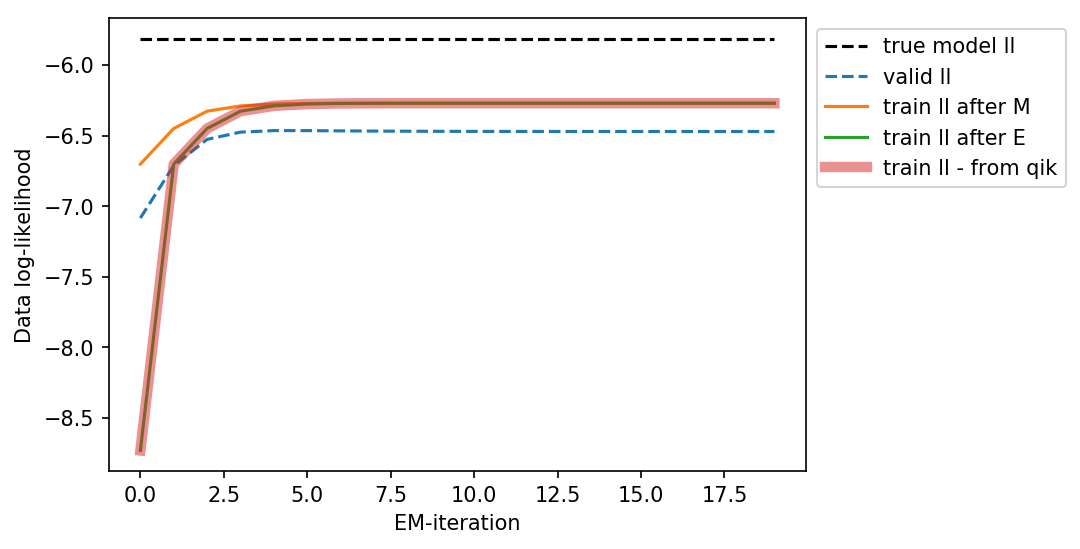

In [15]:
valid_corpus, valid_topics = gen_corpus(1000, n_topics, n_tokens, doc_length, topic_proba, word_proba)

n_iter = 20
n_learned_topics = 6

# We nitialize the learned parameter
# uniform topic proba
learned_topic_proba = np.ones((n_learned_topics,)) / n_learned_topics

# word proba taken from random documents + some constant to avoid zeroes
learned_word_proba = corpus[np.random.permutation(n_docs)[:n_learned_topics]] + 1e-3
learned_word_proba = learned_word_proba / np.sum(learned_word_proba, axis=1)[:, None]

plt.figure(dpi=150)
train_ll = []
train_ll_after_E = []
train_ll_E_step = []
valid_ll = []
for i in range(n_iter):
    # E-step
    doc_topic_probas = E_step(corpus, learned_topic_proba, learned_word_proba)
    # TODO: After E-step call log_likelihood_q_ik on the training data and append this value to train_ll_E_step
    train_ll_E_step.append(log_likelihood_qik(corpus, doc_topic_probas, learned_word_proba, learned_topic_proba))
    
    # TODO: After E-step, also call log_likelihood on the training data and  append this value to train_ll_after_E
    train_ll_after_E.append(log_likelihood(corpus, learned_word_proba, learned_topic_proba))
    
    # M-step
    learned_topic_proba, learned_word_proba = M_step(corpus, doc_topic_probas)
    
    # TODO: After M-step compute the log-likelihoods and append these values to train_ll and valid_ll
    train_ll.append(log_likelihood(corpus, learned_word_proba, learned_topic_proba))
    valid_ll.append(log_likelihood(valid_corpus, learned_word_proba, learned_topic_proba))
    
    # This assert checks that each multinomial for learned_word_proba sums to 1
    assert np.all(np.abs(np.sum(learned_word_proba, axis=1) - 1) < 1e-10)
    # This assert checks that learned_topic_proba sums to 1
    assert np.all(np.abs(np.sum(learned_topic_proba) - 1) < 1e-10)
    
# compute valid log-likelihood for the true parameters of the model
true_valid = log_likelihood(corpus, word_proba, topic_proba)
x = range(len(train_ll))
# TODO: plot train_ll, valid_ll, and valid log-likelihood for true parameters. comment
# TODO: plot train_ll, train_ll_E_step, train_ll_after_E. comment
plt.figure(dpi=150)
plt.plot(x, [true_valid] * len(x), '--', c='k', label="true model ll")
plt.plot(x, valid_ll, '--', label="valid ll")
plt.plot(x, train_ll, '-', label="train ll after M")
plt.plot(x, train_ll_after_E, '-', label="train ll after E")
plt.plot(x, train_ll_E_step, '-', label="train ll - from qik", linewidth=5, alpha=0.5)

    
plt.xlabel("EM-iteration")
plt.ylabel("Data log-likelihood")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()


### Question 6:

Plot the learned word_proba along the dataset and original word_probas. Rerun the code with several different random initializations, comment.
<br/>
<br/>
<div style="color:red">
    Notice that the learned centers are close to the true centers often, but are sometimes quite far. This shows the sensitivity of EM to its initialization.
    There is no reason to be able to recover the same colors as the true centers, since in EM, we are only concerned in reproducing the distribution of the data. Any permutation of the centers would give rise to the same distribution.
</div>


### Larger synthetic dataset
Now, we will generate a more realistic synthetic dataset. We will have $1000$ documents of $200$ words each, $10$ topics and $50$ different tokens.
We will randomly generate the parameters of our generative model with uniform <em>topic_proba</em> and <em>word_proba</em> coming from a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) distribution with all parameters equal to $\alpha=0.5$.

### Question 6:
- How can we determine the right number of topics to model this data ?
- Implement this idea in the following cell.

<br/>
<br/>
<div style="color:red">
    To decide the right number of topics, we look at the log-likelihood on the valid dataset. <b>Not the train log-likelihood</b>. We expect the train log-likelihood to always increase with the number of topics, since the representative power only increases.
    In the cell below, I plot the valid log-likelihood for several number of topics, with error bars. I varied the number of documents to show that the sensitivity to the number of topics decreases with the amount of training data (overfitting is harder).
</div>

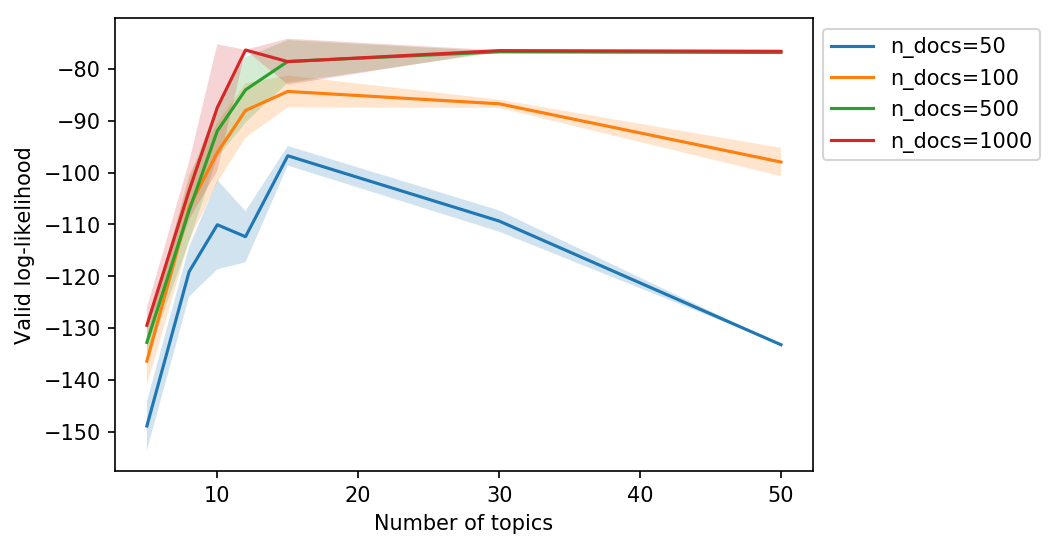

In [6]:
n_valid_docs = 1000
doc_length = 200
n_topics = 10
n_tokens = 50
alpha = 0.5


def gen_bigger_corpus(
    n_train_docs, n_valid_docs, doc_length,
    n_topics, n_tokens, alpha
):
    topic_proba = np.array([1./n_topics] * n_topics)
    word_proba = np.random.dirichlet([alpha] * n_tokens, size=n_topics)

    corpus, topics = gen_corpus(n_train_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)
    valid_corpus, valid_topics = gen_corpus(n_valid_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)
    
    # This is called smoothing : https://en.wikipedia.org/wiki/Smoothing
    corpus += 1e-5
    valid_corpus += 1e-5
    
    return topic_proba, word_proba, corpus, valid_corpus



plt.figure(dpi=150)
for n_train_docs in [50, 100, 500, 1000]:
    topic_proba, word_proba, corpus, valid_corpus = gen_bigger_corpus(
        n_train_docs, n_valid_docs, doc_length,
        n_topics, n_tokens, alpha
    )
    n_iter = 10
    n_tries = 5
    possible_n_topics = [5, 8, 10, 12, 15, 30, 50]
    valid = np.empty((len(possible_n_topics), n_tries))
    for k, n_learned_topics in enumerate(possible_n_topics):
        valid_ll = []
        for t in range(n_tries):
            learned_topic_proba = np.ones((n_learned_topics,)) / n_learned_topics
            learned_word_proba = np.empty((n_learned_topics, n_tokens))
            permutation = np.random.permutation(n_train_docs)
            batch_size = n_train_docs // n_learned_topics
            for t in range(n_learned_topics):
                stats = np.sum(corpus[permutation[t * batch_size: (t+1) * batch_size]], axis=0)
                learned_word_proba[t] = stats / np.sum(stats)

            for i in range(n_iter):
                # E-step
                doc_topic_probas = E_step(corpus, learned_topic_proba, learned_word_proba)
                # M-step
                learned_topic_proba, learned_word_proba = M_step(corpus, doc_topic_probas)
            valid_ll.append(log_likelihood(valid_corpus, learned_word_proba, learned_topic_proba))
        valid[k] = valid_ll

    means = np.mean(valid, axis=1)
    std = np.std(valid, axis=1)

    p, = plt.plot(possible_n_topics, means, label="n_docs={}".format(n_train_docs))
    plt.fill_between(possible_n_topics, means - std, means + std, alpha=0.2) 
    
plt.xlabel("Number of topics")
plt.ylabel("Valid log-likelihood")
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()


# Application to Text
This model is well suited to represent text. In the following, we will apply our EM algorithm to discover topics in the _newsgroup 20_ corpus.

As is standard in Natural Language Processing, we will first apply a few pre-processing steps to the corpus as described [here](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925).

Make sure you have installed the following libraries into your conda environment : 
- gensim
- nltk
- scikit-learn

First, we download the dataset, and wordnet.

In [7]:
import gensim
import nltk

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.datasets import fetch_20newsgroups

newsgroups = {
    'train': fetch_20newsgroups(subset='train', shuffle = True),
    'test': fetch_20newsgroups(subset='test', shuffle = True)
}
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tlacroix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###  Preprocessing :
We use the same pre-processing as in the blog-post :
- **Tokenization** : Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All **stopwords** are removed.
- Words are **lemmatized** - third person is changed to first person, all verbs are changed into present tense
- Words are **stemmed** - words are reduced to their root form.

In [8]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

preprocess("The quick brown fox jumped over the lazy dogs.")

['quick', 'brown', 'jump', 'lazi', 'dog']

### Dictionary making:
Each unique element in the output of _preprocess_ is a token. We need to convert these into unique ids to run our algorithm. This is called building a **dictionary**. The library _gensim_ has a helper function to help us do this.

In [9]:
processed_docs = {s: [] for s in ['train', 'test']}
# This may take a while. We are processing the entire dataset.
for s in ['train', 'test']:
    for doc in newsgroups[s].data:
        processed_docs[s].append(preprocess(doc))
    
dictionary = gensim.corpora.Dictionary(processed_docs['train'])
print(f"{len(dictionary)} unique tokens before filtering")
dictionary.filter_extremes(no_below=15, no_above=0.1)
print(f"{len(dictionary)} unique tokens after filtering")

61411 unique tokens before filtering
6536 unique tokens after filtering


In [10]:
# transform our corpus of text to lists of counts of tokens
bow_corpus = {
    s: [dictionary.doc2bow(doc) for doc in processed_docs[s]]
    for s in ['train', 'test']
}

n_tokens = len(dictionary)
text_corpus = {'train': None, 'test': None}
for s in text_corpus.keys():
    n_docs = len(processed_docs[s])
    text_corpus[s] = np.zeros((n_docs, n_tokens), dtype='int32')
    for d, bow in enumerate(bow_corpus[s]):
        for (id, value) in bow:
            text_corpus[s][d, id] = value

### Model learning
Now that the dataset is ready run EM on it, using $5$ topics. Since the dataset is bigger, this could take some time.

/Users/tlacroix/miniconda3/envs/new_pgm/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/tlacroix/miniconda3/envs/new_pgm/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/tlacroix/miniconda3/envs/new_pgm/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/tlacroix/miniconda3/envs/new_pgm/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/Users/tlacroix/miniconda3/envs/new_pgm/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


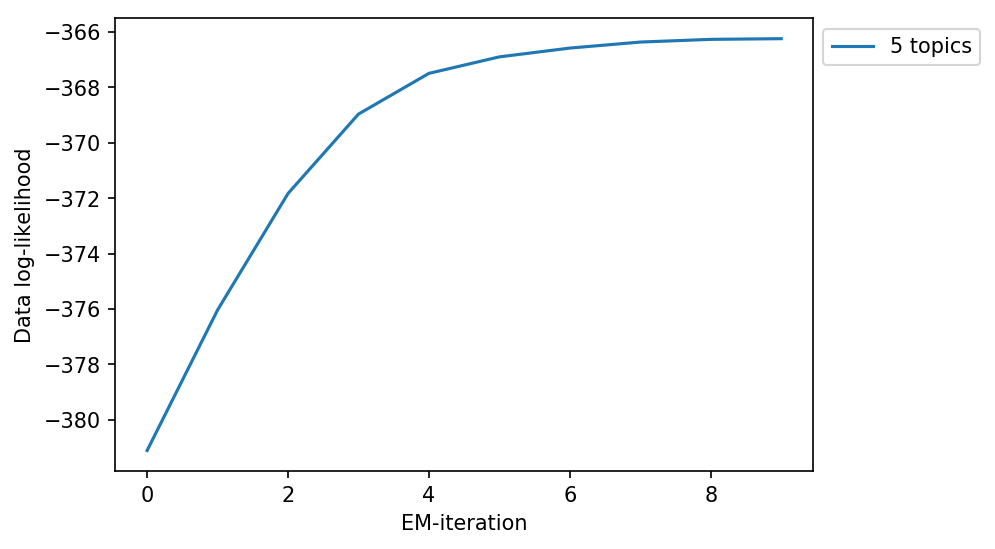

In [11]:
# New E_step using bag of words rather than dense count arrays
def E_step_sparse(corpus, learned_topic_proba, learned_word_proba):
    n_topics = learned_topic_proba.shape[0]
    res = np.zeros((len(corpus), n_topics))
    # This is a bad way of doing this. In practice we should use scipy sparse.
    for d, tuples in enumerate(corpus):
        maxi = np.finfo('float64').min
        for topic in range(n_topics):
            cur = np.log(learned_topic_proba[topic])
            for tok_id, v in tuples:
                tok_prob = learned_word_proba[topic, tok_id]
                cur += np.log(tok_prob) * v
            res[d, topic] = cur
            maxi = max(maxi, cur)
        total = 0
        for topic in range(n_topics):
            total += np.exp(res[d, topic] - maxi)
            res[d, topic] = np.exp(res[d, topic] - maxi)
        res[d, :] /= total

    return res

# New log_likelihood to deal with NaNs
def log_likelihood(corpus, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    all_products = np.log(learned_word_proba[None, :, :]) * corpus[:, None, :]
    all_products[np.isnan(all_products)] = 0
    A = np.sum(all_products, axis=2) + np.log(learned_topic_proba)[None, :] + log_multinomial(corpus)[:, None]
    return np.mean(logsumexp(A))

n_iter = 10
n_topics = 5
n_docs = len(bow_corpus['train'])

learned_topic_proba = np.ones((n_topics,)) / n_topics
learned_word_proba = np.empty((n_topics, n_tokens), dtype='float32')
# initialize topic probabilities with random documents
permutation = np.random.permutation(n_docs)
batch_size = n_docs // n_topics
for t in range(n_topics):
    stats = np.sum(text_corpus['train'][permutation[t * batch_size: (t+1) * batch_size]], axis=0)
    learned_word_proba[t] = stats / np.sum(stats)

train_ll = []
valid_ll = []
for i in range(n_iter):
    # E-step
    doc_topic_probas = E_step_sparse(bow_corpus['train'], learned_topic_proba, learned_word_proba)

    # E-step for valid
    valid_topic_probas = E_step_sparse(bow_corpus['test'], learned_topic_proba, learned_word_proba)

    # M-step
    learned_topic_proba, learned_word_proba = M_step(text_corpus['train'], doc_topic_probas)

    train_ll.append(log_likelihood(text_corpus['train'], learned_word_proba, learned_topic_proba))    
    valid_ll.append(log_likelihood(text_corpus['test'], learned_word_proba, learned_topic_proba))
    
plt.figure(dpi=150)
p, = plt.plot(range(len(train_ll)), train_ll, '-', label=f"{n_topics} topics")
plt.plot(range(len(valid_ll)), valid_ll, '--', c=p.get_color())
    
plt.xlabel("EM-iteration")
plt.ylabel("Data log-likelihood")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()


### Visualizing the topics

Now that we've run EM, we can print the most frequent terms associated to each topics.

In [12]:
print(learned_topic_proba)
for t in range(n_topics):
    most_frequent = np.argsort(learned_word_proba[t])[-10:]
    print(f"------- Topic {t} ------")
    for w in most_frequent:
        print(f"\t -- {dictionary[int(w)]}")

[0.23675354 0.20927628 0.19483104 0.1523612  0.20677794]
------- Topic 0 ------
	 -- live
	 -- high
	 -- cost
	 -- govern
	 -- drive
	 -- power
	 -- engin
	 -- bike
	 -- nasa
	 -- space
------- Topic 1 ------
	 -- data
	 -- softwar
	 -- chip
	 -- avail
	 -- graphic
	 -- version
	 -- imag
	 -- program
	 -- file
	 -- window
------- Topic 2 ------
	 -- isra
	 -- moral
	 -- armenian
	 -- kill
	 -- jew
	 -- live
	 -- israel
	 -- exist
	 -- jesus
	 -- christian
------- Topic 3 ------
	 -- best
	 -- basebal
	 -- score
	 -- pitt
	 -- hockey
	 -- season
	 -- player
	 -- play
	 -- team
	 -- game
------- Topic 4 ------
	 -- hard
	 -- govern
	 -- chip
	 -- window
	 -- disk
	 -- file
	 -- control
	 -- scsi
	 -- card
	 -- drive


### Perplexity
The [perplexity](https://en.wikipedia.org/wiki/Perplexity) of a model $q$ on a test sample $(x_s)$ is given by :
$$2^{-\frac{1}{S}\sum_{s=1}^S\log_2(q(x_s))}$$

### Question 7 :
Explain why this quantity is called perplexity.
<br/>
<br/>
<div style="color:red">
    This quantity represents the log likelihood of the test sample for our model. A high perplexity means that the log-likelihood is very negative, so the sample is unlikely. High perplexity = unlikely sample.
</div>


### Bonus Questions :
- In the code implemented for question 6, what happens when we increase the number of documents in the training set ? Comment.
<br/>
<br/>
<div style="color:red">
    already answered above.
</div>
- What can you notice regarding the computations done in the E-M algorithm for this practical session ? How would you implement this algorithm in a distributed fashion ?
<br/>
<br/>
<div style="color:red">
    We can easily split the computations on several machines or threads. Documents are split between each compute unit, and before each step we share the computed parameters.
</div>